In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import os
from glob import glob
import json
import h5py
from scipy import ndimage, interpolate, optimize
from tqdm import tqdm
import pandas as pd
from sklearn import metrics, model_selection

from sociohydroInferer import *

# Check raw population data first

In [2]:
sc_list = pd.read_csv("/project/vitelli/dsseara/schelling/data/states_counties.csv")

In [3]:
acsfolder = "/project/vitelli/dsseara/schelling/data/yearly/raw/counties/"
acscounties = np.array(sorted(glob(os.path.join(acsfolder, "*/"))))
acs_idxs = [3, 15, 16, 19, 23, 34]
print([acscounties[idx].split("/")[-2] for idx in acs_idxs])

censusfolder = "/project/vitelli/dsseara/schelling/data/decennial/counties/"
censuscounties = np.array(sorted(glob(os.path.join(censusfolder, "*/"))))
census_idxs = [3, 15, 16, 19, 23, 34]
print([censuscounties[idx].split("/")[-2] for idx in census_idxs])

['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Michigan_Wayne', 'New York_Kings', 'Texas_Harris']
['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Michigan_Wayne', 'New York_Kings', 'Texas_Harris']


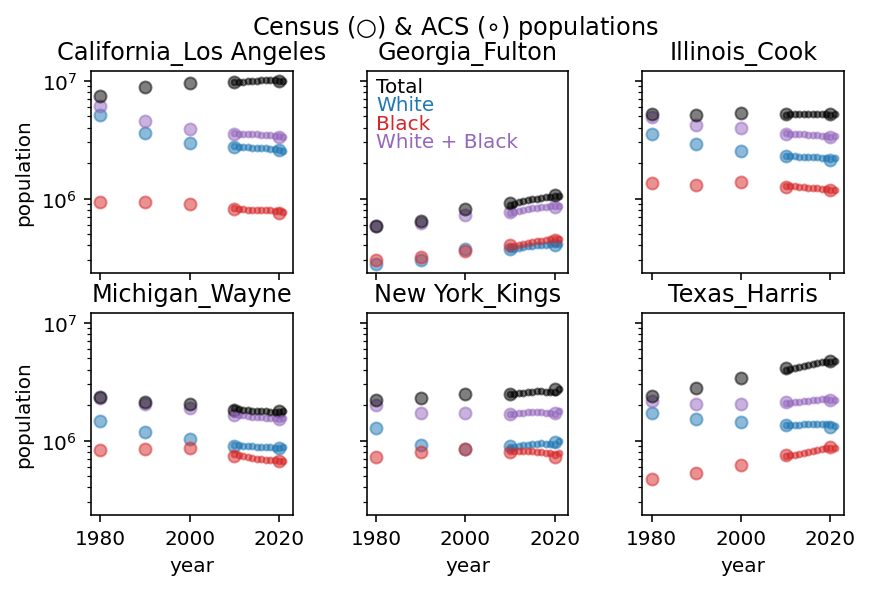

In [4]:
census_years = np.arange(1980, 2021, 10)
acs_years = np.arange(2010, 2022, 1)

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, dpi=144, figsize=(7, 4))
a = ax.ravel()
for axidx, idx in enumerate(census_idxs):
    # census
    censuscounty = censuscounties[idx]
    sc = sc_list.iloc[idx]
    pop_folders = sorted(glob(os.path.join(censuscounty, "*.csv")))
    
    for yidx, pop_folder in enumerate(pop_folders):
        pop = pd.read_csv(pop_folder)
        gisjoin_county = "G" + f"{sc.state_code:02}" + f"{sc.county_code:04}"
        pop_county = pop.iloc[np.where([gisjoin_county in i for i in pop.GISJOIN.values])]
        a[axidx].semilogy(census_years[yidx], pop_county.white.sum(), "C0o", alpha=0.5)
        a[axidx].semilogy(census_years[yidx], pop_county.black.sum(), "C3o", alpha=0.5)
        a[axidx].semilogy(census_years[yidx], pop_county.white.sum() + pop_county.black.sum(), "C4o", alpha=0.5)
        a[axidx].semilogy(census_years[yidx], pop_county.total.sum(), "ko", alpha=0.5)

    # acs
    acscounty = acscounties[idx]
    sc = sc_list.iloc[idx]
    pop_folders = sorted(glob(os.path.join(acscounty, "*.csv")))
    
    for yidx, pop_folder in enumerate(pop_folders):
        pop = pd.read_csv(pop_folder)
        gisjoin_county = "G" + f"{sc.state_code:02}" + f"{sc.county_code:04}"
        pop_county = pop.iloc[np.where([gisjoin_county in i for i in pop.GISJOIN.values])]
        a[axidx].semilogy(acs_years[yidx], pop_county.white.sum(), "C0.", alpha=0.5)
        a[axidx].semilogy(acs_years[yidx], pop_county.black.sum(), "C3.", alpha=0.5)
        a[axidx].semilogy(acs_years[yidx], pop_county.white.sum() + pop_county.black.sum(), "C4.", alpha=0.5)
        a[axidx].semilogy(acs_years[yidx], pop_county.total.sum(), "k.", alpha=0.5)
    
    a[axidx].set(xticks=[census_years.min(), census_years.mean(), census_years.max()],
                 title=acscounty.split("/")[-2])
    a[axidx].set_box_aspect(1)

a[1].text(1980, 0.8e7 * 0.7**0, "Total", color="k", ha="left")
a[1].text(1980, 0.8e7 * 0.7**1, "White", color="C0", ha="left")
a[1].text(1980, 0.8e7 * 0.7**2, "Black", color="C3", ha="left")
a[1].text(1980, 0.8e7 * 0.7**3, "White + Black", color="C4", ha="left")

ax[0, 0].set(ylabel="population")
ax[1, 0].set(ylabel="population")
for aa in ax[1, :]:
    aa.set(xlabel="year")
fig.suptitle(r"Census ($\bigcirc$) & ACS ($\circ$) populations")

fig.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-07_rawPopulations.pdf",
            bbox_inches="tight")

# Now do fitting to gridded data
This is the actual data we will do the inference with

In [5]:
# function to grab total population, not currently implemented in get_data
def get_total(file, year=1990, region="all"):
    ykey = str(year)
    with h5py.File(file, "r") as d:
        x_grid = d[ykey]["x_grid"][()]
        y_grid = d[ykey]["y_grid"][()]
        if region=="all":
            total = d[ykey]["total_grid_masked"][()]
        elif region=="county":
            total = d[ykey]["total_grid_county"][()]

    return total, x_grid, y_grid

In [6]:
acsfolder = "/project/vitelli/dsseara/schelling/data/yearly/raw/gridded"
acscounties = np.array(sorted(glob(os.path.join(acsfolder, "*hdf5"))))
acs_idxs = [0, 1, 2, 3, 4, 5]
print([acscounties[idx].split("/")[-1][:-5] for idx in acs_idxs])

censusfolder = "/project/vitelli/dsseara/schelling/data/decennial/gridded"
censuscounties = np.array(sorted(glob(os.path.join(censusfolder, "*hdf5"))))
census_idxs = [3, 15, 16, 19, 23, 34]
print([censuscounties[idx].split("/")[-1][:-5] for idx in census_idxs])

['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Michigan_Wayne', 'New York_Kings', 'Texas_Harris']
['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Michigan_Wayne', 'New York_Kings', 'Texas_Harris']


### plot totals

100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


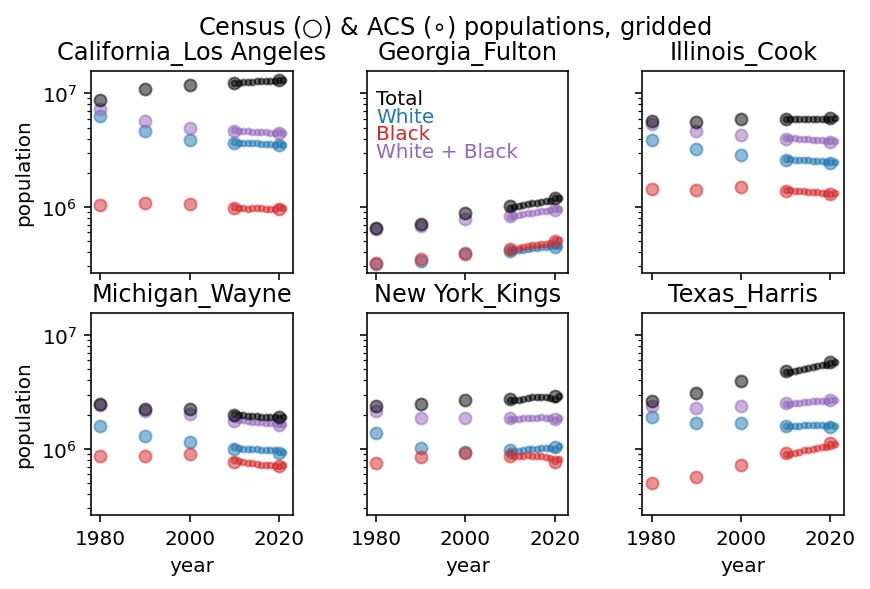

In [7]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, dpi=144, figsize=(7, 4))
a = ax.ravel()

for idx, (censusfile, acsfile) in enumerate(zip(tqdm(censuscounties[census_idxs]),
                                                 acscounties[acs_idxs])):
    ### acs data ###################################
    with h5py.File(acsfile, "r") as d:
        t_acs = np.array([int(k) for k in list(d.keys())])
    
    ϕW_acs = []
    ϕB_acs = []
    ϕtot_acs = []
    for year in t_acs:
        w, b, xx, yy = get_data(acsfile, year=year, region="county", norm=False)
        tot, xx, yy, = get_total(acsfile, year=year, region="county")
        w_border, _, _, _ = get_data(acsfile, year=year, region="county", norm=False)
        ϕW_acs.append(w)
        ϕB_acs.append(b)
        ϕtot_acs.append(tot)
    
    ϕW_acs = np.asarray(ϕW_acs)
    ϕB_acs = np.asarray(ϕB_acs)
    ϕtot_acs = np.asarray(ϕtot_acs)
    
    dx = xx[1, 1] - xx[0, 0]
    dy = yy[1, 1] - yy[0, 0]
    
    nW_acs = np.nansum(ϕW_acs, axis=(1, 2)) * dx * dy
    nB_acs = np.nansum(ϕB_acs, axis=(1, 2)) * dx * dy
    ntot_acs = np.nansum(ϕtot_acs, axis=(1, 2)) * dx * dy
    
    
    a[idx].semilogy(t_acs, nW_acs, "C0.", alpha=0.5)
    a[idx].semilogy(t_acs, nB_acs, "C3.", alpha=0.5)
    a[idx].semilogy(t_acs, nW_acs + nB_acs, "C4.", alpha=0.5)
    a[idx].semilogy(t_acs, ntot_acs, "k.", alpha=0.5)
    ###################################################
    
    ### census data ###################################
    with h5py.File(censusfile, "r") as d:
        t_census = np.array([int(k) for k in list(d.keys())])
    
    ϕW_census = []
    ϕB_census = []
    ϕtot_census = []
    for year in t_census:
        w, b, xx, yy = get_data(censusfile, year=year, region="county", norm=False)
        tot, xx, yy, = get_total(censusfile, year=year, region="county")
        w_border, _, _, _ = get_data(censusfile, year=year, region="county", norm=False)
        ϕW_census.append(w)
        ϕB_census.append(b)
        ϕtot_census.append(tot)
    
    ϕW_census = np.asarray(ϕW_census)
    ϕB_census = np.asarray(ϕB_census)
    ϕtot_census = np.asarray(ϕtot_census)
    
    dx = xx[1, 1] - xx[0, 0]
    dy = yy[1, 1] - yy[0, 0]
    
    nW_census = np.nansum(ϕW_census, axis=(1, 2)) * dx * dy
    nB_census = np.nansum(ϕB_census, axis=(1, 2)) * dx * dy
    ntot_census = np.nansum(ϕtot_census, axis=(1, 2)) * dx * dy
    
    
    a[idx].semilogy(t_census, nW_census, "C0o", alpha=0.5)
    a[idx].semilogy(t_census, nB_census, "C3o", alpha=0.5)
    a[idx].semilogy(t_census, nW_census + nB_census, "C4o", alpha=0.5)
    a[idx].semilogy(t_census, ntot_census, "ko", alpha=0.5)
    ###################################################
    
    a[idx].set(xticks=[t_census.min(), t_census.mean(), t_census.max()],
                 title=censusfile.split("/")[-1][:-5])
    a[idx].set_box_aspect(1)

a[1].text(1980, 0.8e7 * 0.7**0, "Total", color="k", ha="left")
a[1].text(1980, 0.8e7 * 0.7**1, "White", color="C0", ha="left")
a[1].text(1980, 0.8e7 * 0.7**2, "Black", color="C3", ha="left")
a[1].text(1980, 0.8e7 * 0.7**3, "White + Black", color="C4", ha="left")

ax[0, 0].set(ylabel="population")
ax[1, 0].set(ylabel="population")
for aa in ax[1, :]:
    aa.set(xlabel="year")
fig.suptitle(r"Census ($\bigcirc$) & ACS ($\circ$) populations, gridded")

fig.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-07_griddedPopulations.pdf",
            bbox_inches="tight")

### plot fill fractions

 33%|███▎      | 2/6 [00:00<00:01,  2.78it/s]/scratch/local/jobs/22692572/ipykernel_3332255/2974418051.py:22: RuntimeWarning: divide by zero encountered in true_divide
  ϕW.append(w / (1.1 * capacity))
/scratch/local/jobs/22692572/ipykernel_3332255/2974418051.py:23: RuntimeWarning: divide by zero encountered in true_divide
  ϕB.append(b / (1.1 * capacity))
100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


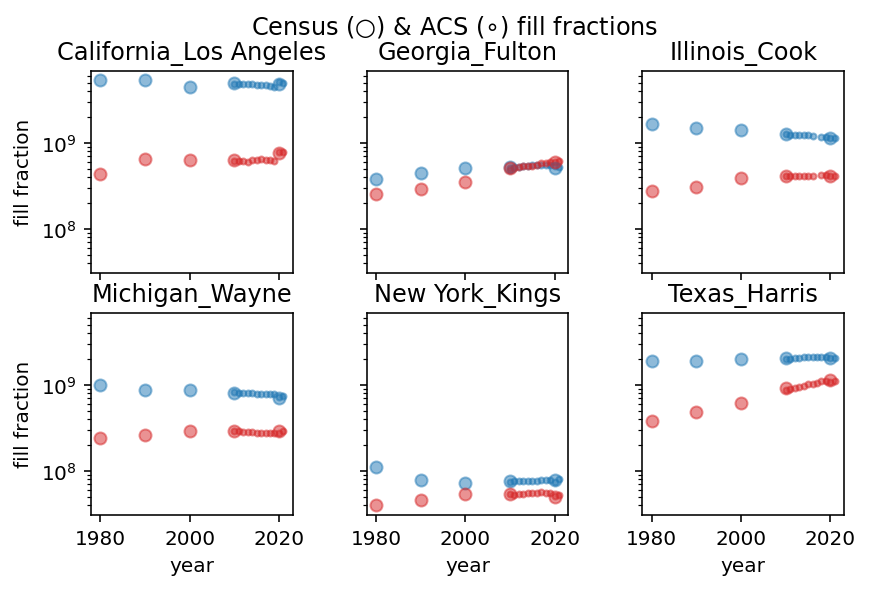

In [8]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, dpi=144, figsize=(7, 4))
a = ax.ravel()

for idx, (censusfile, acsfile) in enumerate(zip(tqdm(censuscounties[census_idxs]),
                                                 acscounties[acs_idxs])):

    # get carrying capacity to use for both census and acs data
    capacity = get_capacity(censusfile, region="county", method="wb")
    
    ### acs data ###################################
    with h5py.File(acsfile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    
    ϕW = []
    ϕB = []
    ϕtot = []
    for year in t:
        w, b, xx, yy = get_data(acsfile, year=year, region="county",
                                norm=False, method="wb")
        w_border, _, _, _ = get_data(acsfile, year=year, region="county",
                                     norm=False, method="wb")
        ϕW.append(w / (1.1 * capacity))
        ϕB.append(b / (1.1 * capacity))
    
    ϕW = np.asarray(ϕW)
    ϕB = np.asarray(ϕB)
    
    dx = xx[1, 1] - xx[0, 0]
    dy = yy[1, 1] - yy[0, 0]
    
    nW = np.nansum(ϕW, axis=(1, 2)) * dx * dy
    nB = np.nansum(ϕB, axis=(1, 2)) * dx * dy
    
    
    a[idx].semilogy(t, nW, "C0.", alpha=0.5)
    a[idx].semilogy(t, nB, "C3.", alpha=0.5)
    ###################################################
    
    ### census data ###################################
    with h5py.File(censusfile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    
    ϕW = []
    ϕB = []
    ϕtot = []
    for year in t:
        w, b, xx, yy = get_data(censusfile, year=year, region="county",
                                norm=False, method="wb")
        w_border, _, _, _ = get_data(censusfile, year=year, region="county",
                                     norm=False, method="wb")
        ϕW.append(w / (1.1 * capacity))
        ϕB.append(b / (1.1 * capacity))
    
    ϕW = np.asarray(ϕW)
    ϕB = np.asarray(ϕB)
    
    dx = xx[1, 1] - xx[0, 0]
    dy = yy[1, 1] - yy[0, 0]
    
    nW = np.nansum(ϕW, axis=(1, 2)) * dx * dy
    nB = np.nansum(ϕB, axis=(1, 2)) * dx * dy
    
    
    a[idx].semilogy(t, nW, "C0o", alpha=0.5)
    a[idx].semilogy(t, nB, "C3o", alpha=0.5)
    ###################################################
    
    a[idx].set(xticks=[t.min(), t.mean(), t.max()],
                 title=censusfile.split("/")[-1][:-5])
    a[idx].set_box_aspect(1)

# a[1].text(1980, 0.8e7 * 0.7**0, "Total", color="k", ha="left")
# a[1].text(1980, 0.8e7 * 0.7**1, "White", color="C0", ha="left")
# a[1].text(1980, 0.8e7 * 0.7**2, "Black", color="C3", ha="left")
# a[1].text(1980, 0.8e7 * 0.7**3, "White + Black", color="C4", ha="left")

ax[0, 0].set(ylabel="fill fraction")
ax[1, 0].set(ylabel="fill fraction")
for aa in ax[1, :]:
    aa.set(xlabel="year")
fig.suptitle(r"Census ($\bigcirc$) & ACS ($\circ$) fill fractions");

fig.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-07_fillFractionsTotal.pdf",
            bbox_inches="tight")

# fit lines to data

In [9]:
def expGrowth(x, a, b, c):
    return growth(x, a, b, c, form="exp")

def linGrowth(x, a, b):
    return growth(x, a, b, 0, form="linear")

 33%|███▎      | 2/6 [00:00<00:00,  5.84it/s]/scratch/local/jobs/22692572/ipykernel_3332255/2011593154.py:38: RuntimeWarning: divide by zero encountered in true_divide
  ϕW_acs = ρW_acs / (1.1 * capacity)
/scratch/local/jobs/22692572/ipykernel_3332255/2011593154.py:46: RuntimeWarning: divide by zero encountered in true_divide
  ϕB_acs = ρB_acs / (1.1 * capacity)
100%|██████████| 6/6 [00:00<00:00,  8.00it/s]


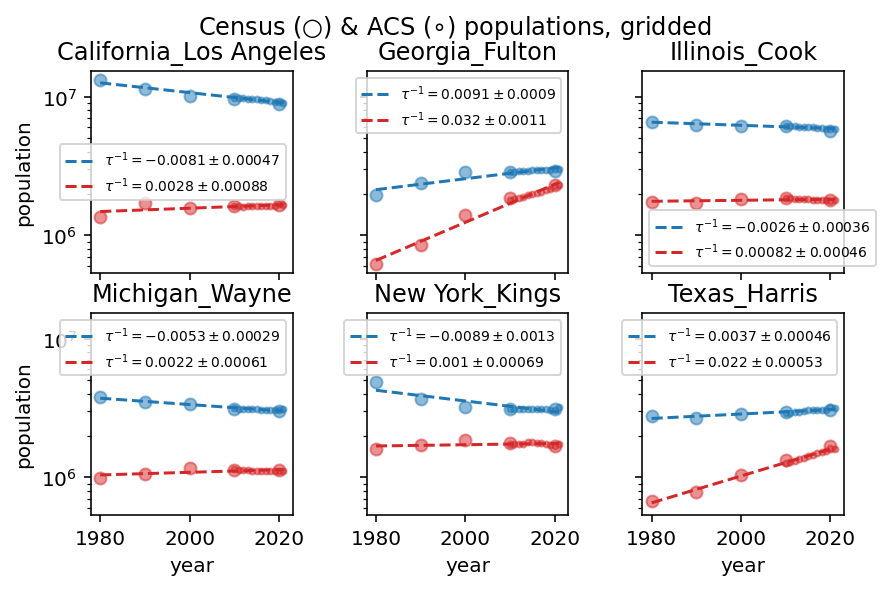

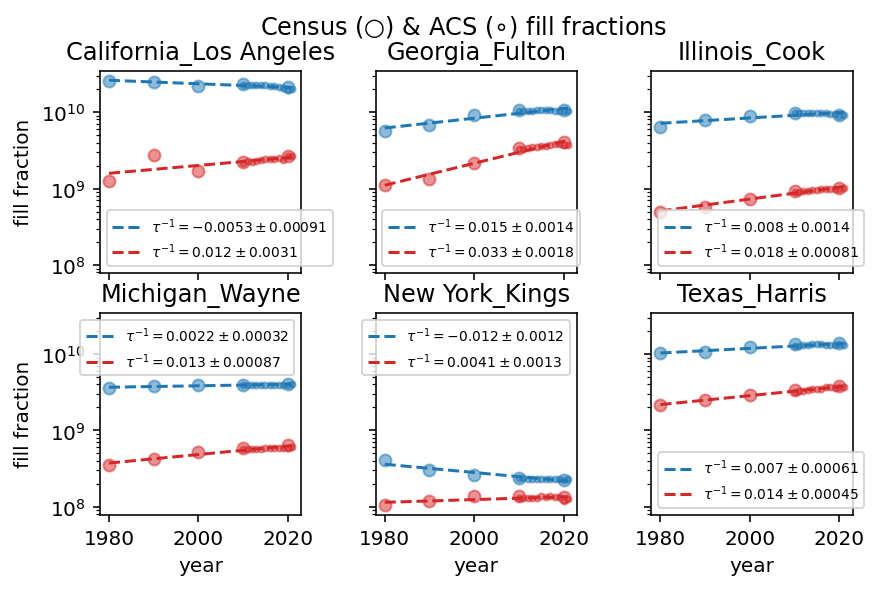

In [22]:
fig_pop, ax_pop = plt.subplots(2, 3, sharey=True, sharex=True, dpi=144, figsize=(7, 4))
fig_fill, ax_fill = plt.subplots(2, 3, sharey=True, sharex=True, dpi=144, figsize=(7, 4))

a_pop  = ax_pop.ravel()
a_fill = ax_fill.ravel()

σ = 2.0

state = []
county = []
growthW = []
growthB = []

for idx, (censusfile, acsfile) in enumerate(zip(tqdm(censuscounties[census_idxs]),
                                                 acscounties[acs_idxs])):

    # first get common carrying capacity
    capacity = get_capacity(censusfile, region="all", method="wb")
    
    ### acs data ###################################
    with h5py.File(acsfile, "r") as d:
        t_acs = np.array([int(k) for k in list(d.keys())])
    
    ρW_acs = []
    ρB_acs = []
    for year in t_acs:
        w, b, xx, yy = get_data(acsfile, year=year, region="all",
                                norm=False, method="wb")
        w_border, _, _, _ = get_data(acsfile, year=year, region="all",
                                     norm=False, method="wb")
        ρW_acs.append(w)
        ρB_acs.append(b)
    
    ρW_acs = np.asarray(ρW_acs)
    ρB_acs = np.asarray(ρB_acs)

    # white population
    ϕW_acs = ρW_acs / (1.1 * capacity)
    ϕW_acs[ϕW_acs>1] = np.nan
    maskW = np.isnan(ϕW_acs)
    ϕW_acs_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW_acs),
                                            σ, axes=[1, 2])
    ϕW_acs_smooth[maskW] = np.nan

    # black population
    ϕB_acs = ρB_acs / (1.1 * capacity)
    ϕB_acs[ϕB_acs>1] = np.nan
    maskB = np.isnan(ϕB_acs)
    ϕB_acs_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB_acs),
                                            σ, axes=[1, 2])
    ϕB_acs_smooth[maskB] = np.nan
    
    dx = xx[1, 1] - xx[0, 0]
    dy = yy[1, 1] - yy[0, 0]
    
    popW_acs = np.ma.masked_invalid(ρW_acs).sum(axis=(1, 2)) * dx * dy
    popB_acs = np.ma.masked_invalid(ρB_acs).sum(axis=(1, 2)) * dx * dy
    fillW_acs = np.ma.masked_invalid(ϕW_acs_smooth).sum(axis=(1, 2)) * dx * dy
    fillB_acs = np.ma.masked_invalid(ϕB_acs_smooth).sum(axis=(1, 2)) * dx * dy

    a_pop[idx].semilogy(t_acs, popW_acs, "C0.", alpha=0.5)
    a_pop[idx].semilogy(t_acs, popB_acs, "C3.", alpha=0.5)
    a_fill[idx].semilogy(t_acs, fillW_acs, "C0.", alpha=0.5)
    a_fill[idx].semilogy(t_acs, fillB_acs, "C3.", alpha=0.5)
    ###################################################
    
    ### census data ###################################
    with h5py.File(censusfile, "r") as d:
        t_census = np.array([int(k) for k in list(d.keys())])
    
    ρW_census = []
    ρB_census = []
    for year in t_census:
        w, b, xx, yy = get_data(censusfile, year=year, region="all",
                                norm=False, method="wb")
        w_border, _, _, _ = get_data(censusfile, year=year, region="all",
                                     norm=False, method="wb")
        ρW_census.append(w)
        ρB_census.append(b)
    
    ρW_census = np.asarray(ρW_census)
    ρB_census = np.asarray(ρB_census)
    
    # white population
    ϕW_census = ρW_census / (1.1 * capacity)
    ϕW_census[ϕW_census>1] = np.nan
    maskW = np.isnan(ϕW_census)
    ϕW_census_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW_census),
                                            σ, axes=[1, 2])
    ϕW_census_smooth[maskW] = np.nan

    # black population
    ϕB_census = ρB_census / (1.1 * capacity)
    ϕB_census[ϕB_census>1] = np.nan
    maskB = np.isnan(ϕB_census)
    ϕB_census_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB_census),
                                            σ, axes=[1, 2])
    ϕB_census_smooth[maskB] = np.nan
    
    dx = xx[1, 1] - xx[0, 0]
    dy = yy[1, 1] - yy[0, 0]
    
    popW_census  = np.nansum(ρW_census, axis=(1, 2)) * dx * dy
    popB_census  = np.nansum(ρB_census, axis=(1, 2)) * dx * dy
    fillW_census = np.nansum(ϕW_census_smooth, axis=(1, 2)) * dx * dy
    fillB_census = np.nansum(ϕB_census_smooth, axis=(1, 2)) * dx * dy

    a_pop[idx].semilogy(t_census, popW_census, "C0o", alpha=0.5)
    a_pop[idx].semilogy(t_census, popB_census, "C3o", alpha=0.5)
    a_fill[idx].semilogy(t_census, fillW_census, "C0o", alpha=0.5)
    a_fill[idx].semilogy(t_census, fillB_census, "C3o", alpha=0.5)
    ###################################################

    ### fit ###################################
    t = np.concatenate([t_acs, t_census])
    t_order = np.argsort(t)
    t = t[t_order]
    popW = np.concatenate([popW_acs, popW_census])[t_order]
    popB = np.concatenate([popB_acs, popB_census])[t_order]
    fillW = np.concatenate([fillW_acs, fillW_census])[t_order]
    fillB = np.concatenate([fillB_acs, fillB_census])[t_order]

    ### fit of White population ###
    popW_coeffs, popW_cov = optimize.curve_fit(linGrowth, t,
                                               np.log(popW),
                                               p0=[1e-3, -10])
    popW_coeffs_err = np.sqrt(np.diag(popW_cov))
    
    ### fit of Black population ###
    popB_coeffs, popB_cov = optimize.curve_fit(linGrowth, t,
                                               np.log(popB),
                                               p0=[1e-3, -10])
    popB_coeffs_err = np.sqrt(np.diag(popB_cov))
    
    ### fit of White fill fractions ###
    fillW_coeffs, fillW_cov = optimize.curve_fit(linGrowth, t,
                                                 np.log(fillW),
                                                 p0=[1e-3, -10])
    fillW_coeffs_err = np.sqrt(np.diag(fillW_cov))

    ### fit of White fill fractions ###
    fillB_coeffs, fillB_cov = optimize.curve_fit(linGrowth, t,
                                                 np.log(fillB),
                                                 p0=[1e-3, -10])
    fillB_coeffs_err = np.sqrt(np.diag(fillB_cov))
    

    a_pop[idx].plot(t, np.exp(linGrowth(t, *popW_coeffs)), "C0--",
                    label=rf"$\tau^{{-1}} = {{{popW_coeffs[0]:0.2g}}} \pm {{{popW_coeffs_err[0]:0.2g}}}$")
    a_pop[idx].plot(t, np.exp(linGrowth(t, *popB_coeffs)), "C3--",
                    label=rf"$\tau^{{-1}} = {{{popB_coeffs[0]:0.2g}}} \pm {{{popB_coeffs_err[0]:0.2g}}}$")
    
    a_fill[idx].plot(t, np.exp(linGrowth(t, *fillW_coeffs)), "C0--",
                     label=rf"$\tau^{{-1}} = {{{fillW_coeffs[0]:0.2g}}} \pm {{{fillW_coeffs_err[0]:0.2g}}}$")
    a_fill[idx].plot(t, np.exp(linGrowth(t, *fillB_coeffs)), "C3--",
                     label=rf"$\tau^{{-1}} = {{{fillB_coeffs[0]:0.2g}}} \pm {{{fillB_coeffs_err[0]:0.2g}}}$")

    a_pop[idx].legend(fontsize="x-small")
    a_fill[idx].legend(fontsize="x-small")
    ##################################################

    state.append(censusfile.split("/")[-1][:-5].split("_")[0])
    county.append(censusfile.split("/")[-1][:-5].split("_")[1])
    growthW.append(fillW_coeffs[0])
    growthB.append(fillB_coeffs[0])
    
    a_pop[idx].set(xticks=[t_census.min(), t_census.mean(), t_census.max()],
                   title=censusfile.split("/")[-1][:-5])
    a_pop[idx].set_box_aspect(1)
    a_fill[idx].set(xticks=[t_census.min(), t_census.mean(), t_census.max()],
                   title=censusfile.split("/")[-1][:-5])
    a_fill[idx].set_box_aspect(1)



# a[1].text(1980, 0.8e7 * 0.7**0, "Total", color="k", ha="left")
# a[1].text(1980, 0.8e7 * 0.7**1, "White", color="C0", ha="left")
# a[1].text(1980, 0.8e7 * 0.7**2, "Black", color="C3", ha="left")
# a[1].text(1980, 0.8e7 * 0.7**3, "White + Black", color="C4", ha="left")

ax_pop[0, 0].set(ylabel="population")
ax_pop[1, 0].set(ylabel="population")
for aa in ax_pop[1, :]:
    aa.set(xlabel="year")
fig_pop.suptitle(r"Census ($\bigcirc$) & ACS ($\circ$) populations, gridded");

# fig_pop.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-07_griddedPopulations+fits_includeSurroundingRegion.pdf",
#                 bbox_inches="tight")

ax_fill[0, 0].set(ylabel="fill fraction")
ax_fill[1, 0].set(ylabel="fill fraction")
for aa in ax_fill[1, :]:
    aa.set(xlabel="year")
fig_fill.suptitle(r"Census ($\bigcirc$) & ACS ($\circ$) fill fractions");

# fig_fill.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-07_fillFractionsTotal+fits_includeSurroundingRegion.pdf",
#                  bbox_inches="tight")

In [23]:
growth_rates = pd.DataFrame({"state":state,
                             "county":county,
                             "growthW": growthW,
                             "growthB": growthB})
growth_rates.to_csv("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-07_fillFractionGrowthRates_includeSurroundingRegion.csv",
                    index=False)

# first attempt at fitting data -- unsuccessful

## ACS Data

In [10]:
idxs = [3, 14, 15, 18, 22, 33]

 50%|█████     | 3/6 [00:05<00:05,  1.74s/it]/scratch/local/jobs/22421876/ipykernel_3056642/36804162.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  poptW, pcovW = optimize.curve_fit(expGrowth, t_interp,
 67%|██████▋   | 4/6 [00:06<00:03,  1.63s/it]/scratch/local/jobs/22421876/ipykernel_3056642/36804162.py:42: OptimizeWarning: Covariance of the parameters could not be estimated
  poptB, pcovB = optimize.curve_fit(expGrowth, t_interp,
100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


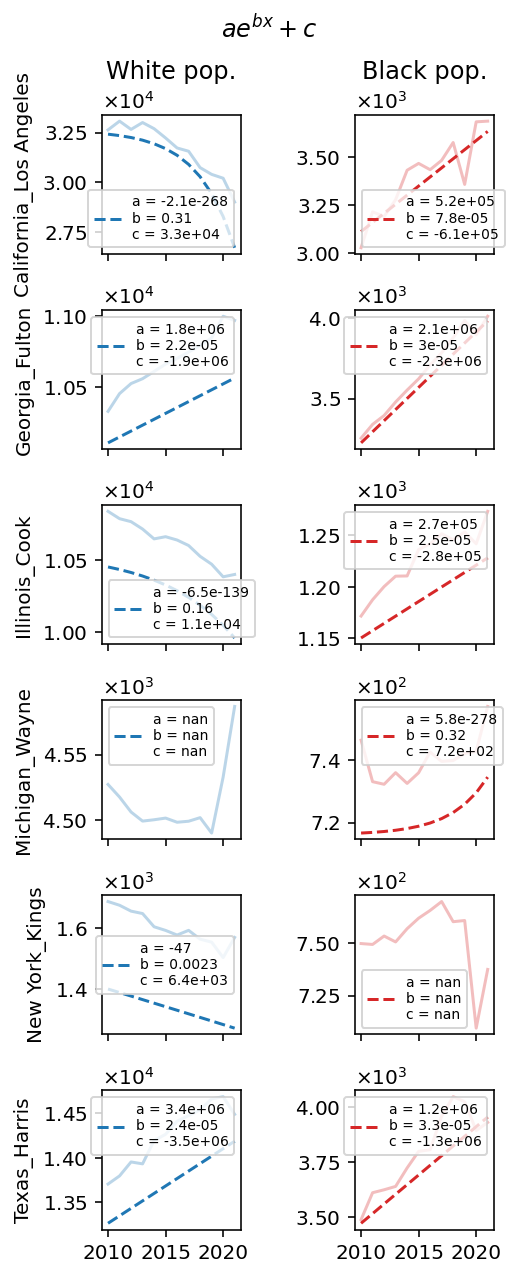

In [11]:
fig, ax = plt.subplots(len(idxs), 2, dpi=144, figsize=(4, 1.5*len(idxs)), sharey=False, sharex=True)

σ = 2.0
for didx, datafile in enumerate(tqdm(list(np.array(acsfiles)[idxs]))):

    # get times and interp times
    with h5py.File(datafile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    t_interp = np.linspace(t[0], t[-1], 101)
    
    ϕW = []
    ϕB = []
    for year in t:
        w, b, xx, yy = get_data(datafile, year=year, region="all", norm=True)
        w_border, _, _, _ = get_data(datafile, year=year, region="all", norm=True)
        ϕW.append(w)
        ϕB.append(b)

    # white demographic data
    ϕW = np.asarray(ϕW)
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW),
                                        σ, axes=[1, 2])
    cubicW = interpolate.interp1d(t, ϕW_smooth, axis=0, kind="cubic")
    ϕW_smooth_interp = cubicW(t_interp)
    ϕW_smooth_interp[:, np.any(np.isnan(ϕW), axis=0)] = np.nan
    # ϕWs.append(ϕW_smooth_interp)

    # black demographic data
    ϕB = np.asarray(ϕB)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB),
                                        σ, axes=[1, 2])
    cubicB = interpolate.interp1d(t, ϕB_smooth, axis=0, kind="cubic")
    ϕB_smooth_interp = cubicB(t_interp)
    ϕB_smooth_interp[:, np.any(np.isnan(ϕB), axis=0)] = np.nan
    # ϕBs.append(ϕB_smooth_interp)
    
    try:
        poptW, pcovW = optimize.curve_fit(expGrowth, t_interp,
                                          np.nansum(ϕW_smooth_interp, axis=(1, 2)),
                                          p0=[1e-3, 1e-6, 0],
                                          maxfev=int(1e5))
        poptB, pcovB = optimize.curve_fit(expGrowth, t_interp,
                                          np.nansum(ϕB_smooth_interp, axis=(1, 2)),
                                          p0=[1e-3, 1e-6, 0],
                                          maxfev=int(1e5))
    except Exception as e:
        print(e)

    ax[didx, 0].plot(t, np.nansum(ϕW_smooth, axis=(1, 2)),
                   "C0", zorder=-1, alpha=0.3)
    ax[didx, 0].plot(t, expGrowth(t, *poptW),
                         color="C0", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptW)]))
    
    ax[didx, 1].plot(t, np.nansum(ϕB_smooth, axis=(1, 2)),
                   "C3", zorder=-1, alpha=0.3)
    ax[didx, 1].plot(t, expGrowth(t, *poptB),
                         color="C3", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptB)]))
    
    ax[didx, 0].set(ylabel=datafile.split("/")[-1][:-5])
    

for a in ax.ravel():
    a.set_box_aspect(1)
    a.set(xticks=[2010, 2015, 2020])
    a.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    a.legend(fontsize="x-small")

ax[0, 0].set(title="White pop.")
ax[0, 1].set(title="Black pop.")

fig.suptitle(r"$a e^{bx} + c$")
plt.tight_layout()
# fig.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-05_ACSGrowthFits_normFalse.pdf")

## Census data

In [13]:
idxs = [3, 15, 16, 19, 23, 34]

100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


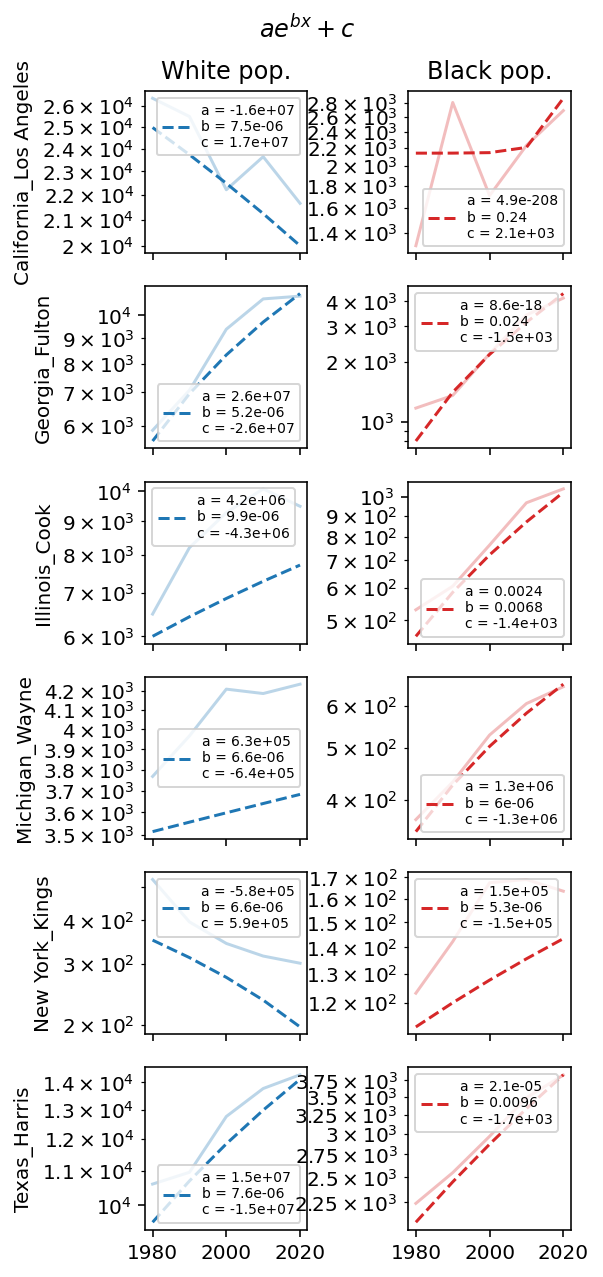

In [17]:
fig, ax = plt.subplots(len(idxs), 2, dpi=144, figsize=(4, 1.5*len(idxs)), sharey=False, sharex=True)

σ = 2.0
for didx, datafile in enumerate(tqdm(list(np.array(censusfiles)[idxs]))):

    # get times and interp times
    with h5py.File(datafile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    t_interp = np.linspace(t[0], t[-1], 101)
    
    ϕW = []
    ϕB = []
    for year in t:
        w, b, xx, yy = get_data(datafile, year=year, region="all", norm=True)
        w_border, _, _, _ = get_data(datafile, year=year, region="all", norm=True)
        ϕW.append(w)
        ϕB.append(b)

    # white demographic data
    ϕW = np.asarray(ϕW)
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW),
                                        σ, axes=[1, 2])
    cubicW = interpolate.interp1d(t, ϕW_smooth, axis=0, kind="cubic")
    ϕW_smooth_interp = cubicW(t_interp)
    ϕW_smooth_interp[:, np.any(np.isnan(ϕW), axis=0)] = np.nan
    # ϕWs.append(ϕW_smooth_interp)

    # black demographic data
    ϕB = np.asarray(ϕB)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB),
                                        σ, axes=[1, 2])
    cubicB = interpolate.interp1d(t, ϕB_smooth, axis=0, kind="cubic")
    ϕB_smooth_interp = cubicB(t_interp)
    ϕB_smooth_interp[:, np.any(np.isnan(ϕB), axis=0)] = np.nan
    # ϕBs.append(ϕB_smooth_interp)
    
    try:
        poptW, pcovW = optimize.curve_fit(expGrowth, t_interp,
                                          np.nansum(ϕW_smooth_interp, axis=(1, 2)),
                                          p0=[1e-3, 1e-6, 0],
                                          maxfev=int(1e5))
        poptB, pcovB = optimize.curve_fit(expGrowth, t_interp,
                                          np.nansum(ϕB_smooth_interp, axis=(1, 2)),
                                          p0=[1e-3, 1e-6, 0],
                                          maxfev=int(1e5))
    except Exception as e:
        print(e)

    ax[didx, 0].semilogy(t, np.nansum(ϕW_smooth, axis=(1, 2)),
                   "C0", zorder=-1, alpha=0.3)
    ax[didx, 0].semilogy(t, expGrowth(t, *poptW),
                         color="C0", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptW)]))
    
    ax[didx, 1].semilogy(t, np.nansum(ϕB_smooth, axis=(1, 2)),
                   "C3", zorder=-1, alpha=0.3)
    ax[didx, 1].semilogy(t, expGrowth(t, *poptB),
                         color="C3", ls="--",
                         label="\n".join([f"{coeff} = {val:0.2g}" for coeff, val in zip(["a", "b", "c"], poptB)]))
    
    ax[didx, 0].set(ylabel=datafile.split("/")[-1][:-5])
    

for a in ax.ravel():
    a.set_box_aspect(1)
    a.set(xticks=[t.min(), t.mean(), t.max()])
    # a.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
    a.legend(fontsize="x-small")

ax[0, 0].set(title="White pop.")
ax[0, 1].set(title="Black pop.")

fig.suptitle(r"$a e^{bx} + c$")
plt.tight_layout()
# fig.savefig("/project/vitelli/dsseara/schelling/data/2024-08-05_inferenceWithGrowth/2024-08-05_CensusGrowthFits_normFalse.pdf")